# NYC Apartment Search Final Project

**Project Group 34: Ziqi Sun (zs2654), Rui Ma(rm4067)**

**Course: 4501 Tools for Analytics, Fall 2023**

Here is the_[GitHub Link](https://github.com/rma241/Final-Project-Group34)_

This notebook contains all the codes used to analyze different criteria that can help to make rental decisions in search of an apartment in New York City.


## Table of Contents

* Setup

* Part 1: Data Preprocessing

* Part 2: Storing Data

    - Creating Tables
    - Add Data to Databse

* Part 3: Understanding the Data

    - Query 1
    - Query 2
    - Query 3
    - Query 4
    - Query 5
    - Query 6

* Part 4: Visualizing the Data

    - Visualization 1
    - Visualization 2
    - Visualization 3
    - Visualization 4
    - Visualization 5
    - Visualization 6







## Setup

This section is to set up some Python libraries and constants that will be used later.

In [1]:
# All import statements needed for the project

import json
import pathlib
import urllib.parse
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import requests
import shapely
import sqlalchemy as db
from sqlalchemy import create_engine, text
import geoalchemy2 as gdb
from geoalchemy2 import WKTElement, Geometry
import numpy as np
from shapely import wkt, wkb
import psycopg2
import binascii
from sqlalchemy.orm import declarative_base


In [2]:
# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp" 
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "ViHT9fZpI3IQw23Bqm2tTgCVE"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

# constants needed to create abnd use postgres sql database.
DB_NAME = "Final_project"
DB_USER = "postgres"
DB_PASSWORD = "yq001018"
DB_HOST = "localhost"  
DB_PORT = "5432" 

DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

# API endpoints used to download data from NYC open data
endpoint_311_1 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
               "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
               "$where= created_date between '2022-10-01' and'2023-10-01'&$limit=3500000&"\
               f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_2 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                 "$where= created_date between '2015-01-01' and'2017-01-01'&$limit=5000000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_3 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                 "$where= created_date between '2017-01-01' and'2019-01-01'&$limit=5300000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_4 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= created_date, incident_zip,complaint_type,latitude,longitude&"\
                 "$where= created_date between '2019-10-01' and'2021-01-01'&$limit=5600000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_5 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                 "$where= created_date between '2021-01-01' and'2022-10-01'&$limit=5700000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_trees = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                 "$select=tree_id,the_geom,zipcode,zip_city,health,spc_common&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=65000 &$where= zip_city='New York'"

## Part 1: Data Preprocessing

All the data loading, downloaing and cleaning will be done in this section using self-defined functions. We rename some columns with clear and simple names and cut unnecessary columns or rows for future convenience.

We have 4 datasets in total: shapefiles of NYC’s zip codes with geometric boundary data, historical NYC 311 service request/compliants data, tree census data across NYC and historical monthly average rents by zip code from Zillow.

In [3]:
def load_and_clean_zipcodes():
    """Load and clean shapefiles of NYC’s zip codes data and return a geopanda dataframe"""
    zipcodes_df = gpd.read_file(ZIPCODE_DATA_FILE)
    zipcodes_df = zipcodes_df[zipcodes_df['PO_NAME'] == 'New York']
    zipcodes_df.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
    zipcodes_df = zipcodes_df.drop_duplicates()
    zipcodes_df = zipcodes_df.to_crs(epsg=4326)
    return zipcodes_df[["zipcode","geometry"]]

In [4]:
def download_and_clean_311_data():
    """Download and clean historical NYC 311 compliants data and return a geopanda dataframe"""
    content = requests.get(endpoint_311_1)
    data_311_1 = gpd.read_file(content.text)
    
    content = requests.get(endpoint_311_2)
    data_311_2 = gpd.read_file(content.text)
    
    content = requests.get(endpoint_311_3)
    data_311_3 = gpd.read_file(content.text)
    
    content = requests.get(endpoint_311_4)
    data_311_4 = gpd.read_file(content.text)
    
    content = requests.get(endpoint_311_5)
    data_311_5 = gpd.read_file(content.text)
    
    data_311 = pd.concat([data_311_1, data_311_2, data_311_3, data_311_4, data_311_5], axis=0, ignore_index=True)
    data_311.rename(columns={"incident_zip": 'zipcode'}, inplace=True) 
    
    if "geometry" in data_311.columns:
        data_311.drop('geometry',axis=1,inplace=True)
    
    return data_311

In [5]:
def download_and_clean_tree_data():
    """Download and clean the tree census data and return a geopanda dataframe"""
    content = requests.get(endpoint_trees)
    data_tree = gpd.read_file(content.text).reset_index()
    
    data_tree.rename(columns={data_tree.columns[4]: 'species'}, inplace=True)
    data_tree.rename(columns={data_tree.columns[6]: 'geometry'}, inplace=True)
    return data_tree[["tree_id","geometry","zipcode","health","species"]]

In [6]:
def load_and_clean_zillow_data():
    """Load and clean Zillow data and return a panda dataframe"""
    zillow_df = gpd.read_file(ZILLOW_DATA_FILE)
    zillow_df = zillow_df[zillow_df['City'] == 'New York']
    date_columns = [col for col in zillow_df if col >= '2015-01-31' and col <= '2023-09-30']

    for col in date_columns:
        zillow_df[col] = pd.to_numeric(zillow_df[col], errors='coerce')
        
    zillow_df.rename(columns={'RegionID': 'regionid'},inplace=True)
    zillow_df.rename(columns={'RegionName': 'zipcode'},inplace=True)
    
    zillow_df['average_rent'] = zillow_df[date_columns].mean(axis=1, skipna=True)
    
    return zillow_df[["regionid",'zipcode','2023-01-31','2023-08-31','2023-09-30','average_rent']]

In [7]:
def load_all_data():
    """Load all data and return them as a tuple of 4 dataframes"""
    geodf_zipcode_data = load_and_clean_zipcodes()
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [8]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

For each dataframe, basic infos and the first 5 entries are shown:

**The zipcode data:**

In [9]:
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 110 entries, 21 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   110 non-null    object  
 1   geometry  110 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.6+ KB


In [10]:
geodf_zipcode_data.head()

,zipcode,geometry
21,10034,"POLYGON ((-73.92062 40.87300, -73.92058 40.873..."
22,10033,"POLYGON ((-73.93213 40.86945, -73.93186 40.869..."
24,10040,"POLYGON ((-73.93379 40.86307, -73.93367 40.863..."
32,10032,"POLYGON ((-73.94692 40.85053, -73.94688 40.850..."
36,10031,"POLYGON ((-73.94009 40.83035, -73.93979 40.829..."


**The 311 compliants data:**

In [11]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22303017 entries, 0 to 22303016
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        object        
 1   created_date    datetime64[ns]
 2   longitude       object        
 3   zipcode         object        
 4   complaint_type  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 850.8+ MB


In [12]:
geodf_311_data.head()

,latitude,created_date,longitude,zipcode,complaint_type
0,40.655672001198894,2023-09-30 23:59:58,-73.95917686020623,11226,Noise - Street/Sidewalk
1,40.76675595839554,2023-09-30 23:59:38,-73.78751847563191,11361,Noise - Residential
2,40.71949965458691,2023-09-30 23:59:35,-73.98486650733275,10002,Noise - Commercial
3,40.687499303408536,2023-09-30 23:59:34,-73.7972903094197,11435,Noise - Residential
4,40.65220215349917,2023-09-30 23:59:28,-73.9579464603267,11226,Noise - Residential


**The tree census data:**

In [13]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64488 entries, 0 to 64487
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tree_id   64488 non-null  object  
 1   geometry  64488 non-null  geometry
 2   zipcode   64488 non-null  object  
 3   health    61495 non-null  object  
 4   species   61496 non-null  object  
dtypes: geometry(1), object(4)
memory usage: 2.5+ MB


In [14]:
geodf_tree_data.head()

,tree_id,geometry,zipcode,health,species
0,190422,POINT (-73.98495 40.77005),10023,Good,honeylocust
1,190426,POINT (-73.98534 40.77021),10023,Good,honeylocust
2,208649,POINT (-73.98730 40.76272),10019,Good,American linden
3,193310,POINT (-73.96046 40.77217),10021,Good,honeylocust
4,199760,POINT (-73.98096 40.78209),10024,Fair,willow oak


**The Zillow rents data:**

In [15]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 4 to 6721
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   regionid      145 non-null    object 
 1   zipcode       145 non-null    object 
 2   2023-01-31    121 non-null    float64
 3   2023-08-31    138 non-null    float64
 4   2023-09-30    145 non-null    float64
 5   average_rent  145 non-null    float64
dtypes: float64(4), object(2)
memory usage: 7.9+ KB


In [16]:
df_zillow_data.head()

,regionid,zipcode,2023-01-31,2023-08-31,2023-09-30,average_rent
4,62093,11385,2895.699421,3064.476503,3079.585783,2476.923402
6,62019,11208,2588.030194,2737.547470,2728.733333,2560.469803
12,62046,11236,NaN,2285.460026,2362.500000,2323.980013
13,61807,10467,2155.617718,2353.686402,2423.888889,1861.072982
14,62085,11373,2255.604528,2302.557354,2292.994444,2084.549636


## Part 2: Storing Data

In this section, we create all 4 database tables and store the data we loaded before into our database.

### Creating Tables

In [17]:
engine = db.create_engine(DB_URL)

In [18]:
# Define the SQL statements for creating 4 tables

ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
        id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geom GEOMETRY
    )
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS nyc_311 (
        id INTEGER PRIMARY KEY,
        created_date DATE,
        zipcode VARCHAR,
        complaint_type VARCHAR,
        longitude REAL,
        latitude REAL
    )
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS trees (
        tree_id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geom GEOMETRY,
        health VARCHAR,
        species VARCHAR
    )
    """

ZILLOW_SCHEMA = f"""
CREATE TABLE IF NOT EXISTS rent (
    regionid INTEGER PRIMARY KEY,
    zipcode VARCHAR,
    "2023-01-31" REAL,
    "2023-08-31" REAL,
    "2023-09-30" REAL,
    average_rent REAL
)
"""

In [19]:
# create the required schema.sql file and write the schemas into the file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [20]:
# Execute the schema files to create tables
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER}")
cur = conn.cursor()
with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Add Data to Database

In [21]:
def write_dataframes_to_table(tablename_to_dataframe):
    """Add data to corresponding tables in our database

    Keyword argument:
    tablename_to_dataframe -- a dictionary with table names as keys and dataframes as values
    """
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            temp_df = dataframe.copy()
            temp_df['the_geom'] = temp_df['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None)
            temp_df.drop('geometry',axis=1,inplace=True)
            temp_df.to_sql(tablename, engine, if_exists='replace', index=False, 
                             dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}) 
            
        else:
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [22]:
tablename_to_dataframe = {
    "zip_codes": geodf_zipcode_data,
    "nyc_311": geodf_311_data,
    "trees": geodf_tree_data,
    "rent": df_zillow_data,
}

In [23]:
#call the function defined above to write dataframes to corresponding tables
write_dataframes_to_table(tablename_to_dataframe)

## Part 3: Understanding the Data

In this section, we research and answer different questions around criterias that affects rental decisions. Each question will be answered using a SQL query. The results are shown after excuting the queries.

In [24]:
def write_query_to_file(query, outfile):
    """Helper function to write the queries to file
    
    Keyword arguments:
    query -- the query statement, a string
    outfile -- path
    """
    with open(outfile, 'w') as file:
        file.write(query)

### Query 1

**Which area might be more calm to live in?**

We looked at the number of 311 complaints per zip code between October 1st, 2022 and September 30th, 2023 (inclusive). 

The printed result has 2 columns: zip code and the number of 311 compliants (in the corresponding order).

In [25]:
QUERY_1_FILENAME = QUERY_DIR / "Q1_311compliants_per_zipcode.sql"

QUERY_1 = """
SELECT zipcode, COUNT(*) as total_complaints
FROM nyc_311
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY total_complaints DESC;
"""

In [26]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

('11226', 49347)
('10467', 47358)
('10468', 44081)
('11385', 43943)
('10452', 43880)
('10457', 41537)
('10458', 41186)
('11207', 40174)
('10456', 39772)
(None, 39696)
('11201', 39344)
('10453', 38106)
('11208', 36761)
('10031', 33863)
('11221', 33109)
('10466', 32584)
('10032', 32046)
('10025', 31105)
('10462', 30760)
('11238', 30181)
('11230', 29683)
('11368', 29225)
('11220', 29065)
('10019', 28322)
('11216', 28159)
('11225', 28076)
('11235', 27838)
('11212', 27355)
('10463', 27053)
('10460', 27011)
('11203', 27000)
('10023', 26961)
('11214', 26777)
('11377', 26384)
('11101', 25995)
('10027', 25899)
('11213', 25893)
('11211', 25572)
('11234', 25567)
('10002', 25564)
('11206', 25410)
('11209', 25380)
('11215', 25331)
('11222', 25330)
('10472', 25313)
('11218', 25079)
('11233', 24972)
('11223', 24336)
('11373', 24098)
('10033', 23676)
('11237', 23391)
('11229', 22860)
('11236', 22719)
('10461', 22367)
('10034', 22334)
('10011', 22196)
('11204', 21787)
('10003', 21772)
('11210', 21423)


In [27]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

**Where has the most greenery?**


We look at the top 10 zip codes with the most trees.

The printed result has 2 columns: zip code and the number of trees (in the corresponding order).


In [28]:
QUERY_2_FILENAME = QUERY_DIR / "Q2_10_zipcodes_have_the_most_trees.sql"

QUERY_2 = """
SELECT zipcode, COUNT(tree_id) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [29]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [30]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

**Can I afford a place in the areas with the most trees?**

Of the top 10 zip codes with the most trees, we look at the average rent by zip code for the month of August 2023.

The printed result has two columns: zip code and the average rent rounded to two decimal places (in the corresponding order). The average rents are rounded to two decimal places.

In [31]:
QUERY_3_FILENAME = QUERY_DIR / "Q3_the_average_rent_of_top10_trees_zipcode .sql"

QUERY_3 = """
SELECT t.zipcode, 
       ROUND(CAST(r."2023-08-31" AS NUMERIC), 2) AS August2023
FROM trees t
JOIN rent r ON t.zipcode = r.zipcode
GROUP BY t.zipcode, r."2023-08-31"
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;
"""

In [32]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10025', Decimal('4037.77'))
('10024', Decimal('3797.94'))
('10027', Decimal('3235.99'))
('10014', Decimal('4899.07'))
('10031', Decimal('2967.04'))
('10029', Decimal('2915.94'))
('10002', Decimal('4078.87'))
('10023', Decimal('4370.07'))
('10032', Decimal('2657.76'))
('10128', Decimal('3565.40'))


In [33]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

**Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?**


For the month of January 2023, we look at the 5 zip code areas with the lowest average rent, and 5 of the highest average rent as well as the number of trees and 311 complaints in those areas.

The printed result has 4 columns: zip code, average rent, tree count, and complaint count (in the corresponding order). The average rents are rounded to two decimal places.

In [34]:
QUERY_4_FILENAME = QUERY_DIR / "Q4_top&bottom5_zipcodes_by_rent_with_trees_compliants_count.sql"

QUERY_4 = """
WITH subquery AS 
(
    SELECT rent.zipcode, rent."2023-01-31", total_trees, total_complaints
    FROM rent
    JOIN 
    (
        SELECT nyc_311.zipcode, COUNT(*) as total_complaints
            FROM nyc_311
            WHERE created_date BETWEEN '2023-01-01' AND '2023-01-31'
            GROUP BY nyc_311.zipcode
    ) nyc_311 ON rent.zipcode = nyc_311.zipcode
    JOIN 
    (
        SELECT trees.zipcode, COUNT(trees.tree_id) as total_trees
            FROM trees
            GROUP BY trees.zipcode
    ) trees ON rent.zipcode = trees.zipcode
    WHERE rent."2023-01-31" IS NOT NULL
) 

SELECT zipcode, ROUND(CAST("2023-01-31" AS NUMERIC),2), total_trees, total_complaints FROM
(
    (
        SELECT *
        FROM subquery
        ORDER BY "2023-01-31" DESC
        LIMIT 5
    )
    UNION
    (
        SELECT * 
        FROM subquery
        ORDER BY "2023-01-31" ASC
        LIMIT 5
    )
)
ORDER BY "2023-01-31" DESC
"""

In [35]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

('10007', Decimal('7270.24'), 355, 250)
('10282', Decimal('7143.35'), 234, 39)
('10013', Decimal('5480.11'), 1202, 740)
('10069', Decimal('4959.67'), 119, 35)
('10011', Decimal('4741.87'), 2134, 1487)
('10030', Decimal('2551.10'), 1365, 1503)
('10033', Decimal('2507.34'), 1971, 1745)
('10037', Decimal('2501.17'), 698, 594)
('10040', Decimal('2166.27'), 1560, 1494)
('10034', Decimal('2164.78'), 1574, 1560)


In [36]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

**Where has the most greenery (take 2)?**

We rewrite Query 2 using another approach.

In [37]:
QUERY_5_FILENAME = QUERY_DIR / "Q5_most_greenery.sql"

QUERY_5 = """
SELECT t.zipcode, COUNT(t.tree_id) AS total_trees
FROM trees t
LEFT JOIN zip_codes z ON ST_Contains(z.the_geom, t.the_geom)
GROUP BY t.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [38]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [39]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

**What is the immediate area like?**

We look at all the trees that are around ½ mile radius of the campus, using the following coordinate pair as the reference point:
    
    (Latitude: 40.80737875669467, Longitude: -73.96253174434912)

The printed result has 5 columns: tree ID, species, health, status, and coordinate location of each tree (in the corresponding order). Coordinates are of the form (longitude, latitude).

In [40]:
QUERY_6_FILENAME = QUERY_DIR / "Q6_trees_within_0.5miles.sql"

QUERY_6 = """
SELECT tree_id, species, health, (ST_X(the_geom), ST_Y(the_geom))
FROM trees
WHERE ST_DWithin(ST_GeomFromText('POINT(-73.96253174434912 40.80737875669467)',4326), the_geom::geography, 804.672)
"""

# ST_DWithin uses meters as units. 
# 0.5 miles = 804.672 meters
# latitude 40.80737875669467 longitude -73.96253174434912

In [41]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

('198514', 'pin oak', 'Good', '(-73.96207980385901,40.80230108588602)')
('209919', 'London planetree', 'Good', '(-73.96331506361766,40.808811547267055)')
('209921', 'London planetree', 'Good', '(-73.96340334087577,40.80874458097537)')
('203887', 'willow oak', 'Good', '(-73.96071917063361,40.805725833688264)')
('196440', 'American elm', 'Fair', '(-73.96412322243684,40.81114537770991)')
('209913', 'pin oak', 'Good', '(-73.96312071522566,40.809077091635245)')
('178550', 'Norway maple', 'Good', '(-73.95739876534434,40.806903447365045)')
('189403', 'Callery pear', 'Fair', '(-73.95861205918303,40.80754134482308)')
('196606', 'honeylocust', 'Good', '(-73.96719943972623,40.80732246649563)')
('198512', 'pin oak', 'Good', '(-73.96230576828576,40.8023961095017)')
('196541', 'honeylocust', 'Good', '(-73.96549830227003,40.80929314213609)')
('203996', 'Callery pear', 'Good', '(-73.96134249273145,40.80528415809051)')
('189414', 'ginkgo', 'Good', '(-73.95983152318928,40.80805619203157)')
('196605', 'A

In [42]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

In this section, we create six plots for a better understanding of the datasets and present straightforward insights around average rents, greenery conditions, and 311 complaints in the neighborhood. 

### Visualization 1

**What can I expect to put up with in NYC?**

The following is a histogram of the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). 

We choose histograms because it can demostrate the number of each complaint types and the contrasts beween them.

In [43]:
def plot_top_3_complaints(dataframe1):
    """Create historgram for Visualization 1
    
    Key argument:
    dataframe1 -- a dataframe
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    
    #Create the bar charts
    axes.bar(dataframe1['complaint_type'], dataframe1['complaint_count'])
    axes.set_title("Top 3 Complaint Types from October 1st, 2022 to September 30th, 2023 ")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Complaint Count")
    
    plt.show()

In [44]:
def get_data_for_visual_1():
    """Query the data required for visualization 1 and return it as a dataframe"""
    
    V1 = """
    SELECT complaint_type, COUNT(*) AS complaint_count
    FROM nyc_311
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V1))
        dataframe1 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe1

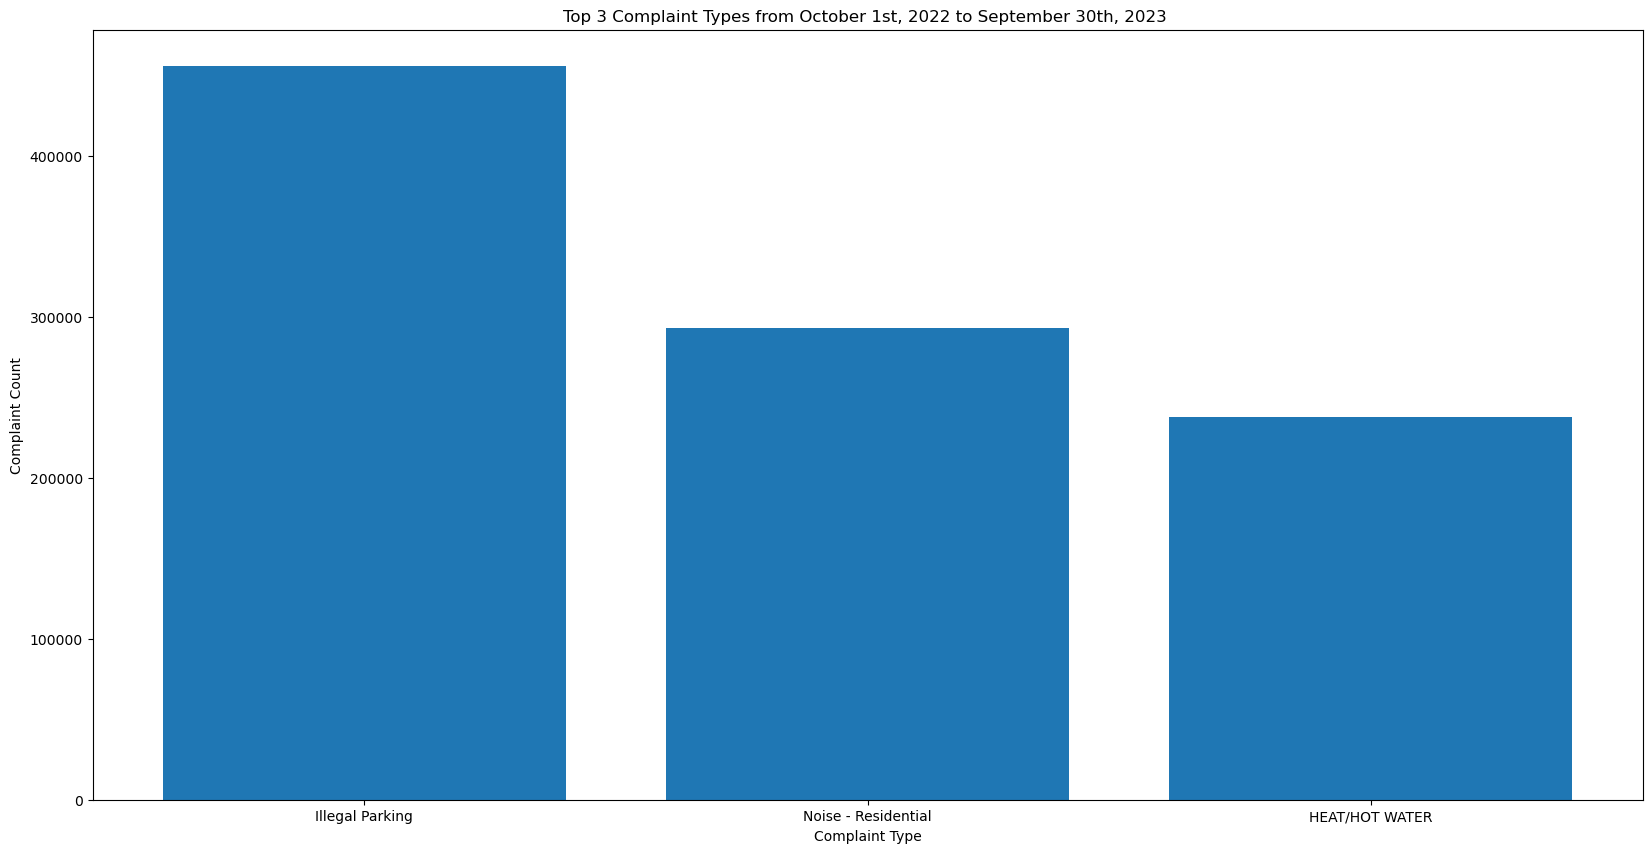

In [45]:
some_dataframe1 = get_data_for_visual_1()
plot_top_3_complaints(some_dataframe1)

### Visualization 2

**What are the most common complaints in the immediate area?**

The following is a histogram of the top 10 complaint types in zip code area 10027 from October 1st, 2018 to September 30th, 2023 (inclusive).

We choose histograms because it can demostrate the number of each complaint types and the contrasts beween them clearly.

In [46]:
def plot_top_10_complaints(dataframe2):
    """Create historgram for Visualization 1
    
    Key argument:
    dataframe2 -- a dataframe
    """
    fig, axes = plt.subplots(figsize=(20, 10))
    
    complaint_types = dataframe2['complaint_type']
    complaint_counts = dataframe2['complaint_count']
    
    #Create the bar charts
    bars = axes.bar(complaint_types, complaint_counts)
    axes.set_title('Top 10 Complaints in Zip Code 10027')
    axes.set_xlabel('Complaint Type')
    axes.set_ylabel('Complaint Count')
    plt.xticks(fontsize=6.5)
    
    plt.show()

In [47]:
def get_data_for_visual_2():
    """Query the data required for visualization 2 and return it as a dataframe"""
    
    V2 = """
    SELECT complaint_type, COUNT(*) AS complaint_count
    FROM nyc_311
    WHERE zipcode = '10027' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V2))
        dataframe2 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe2

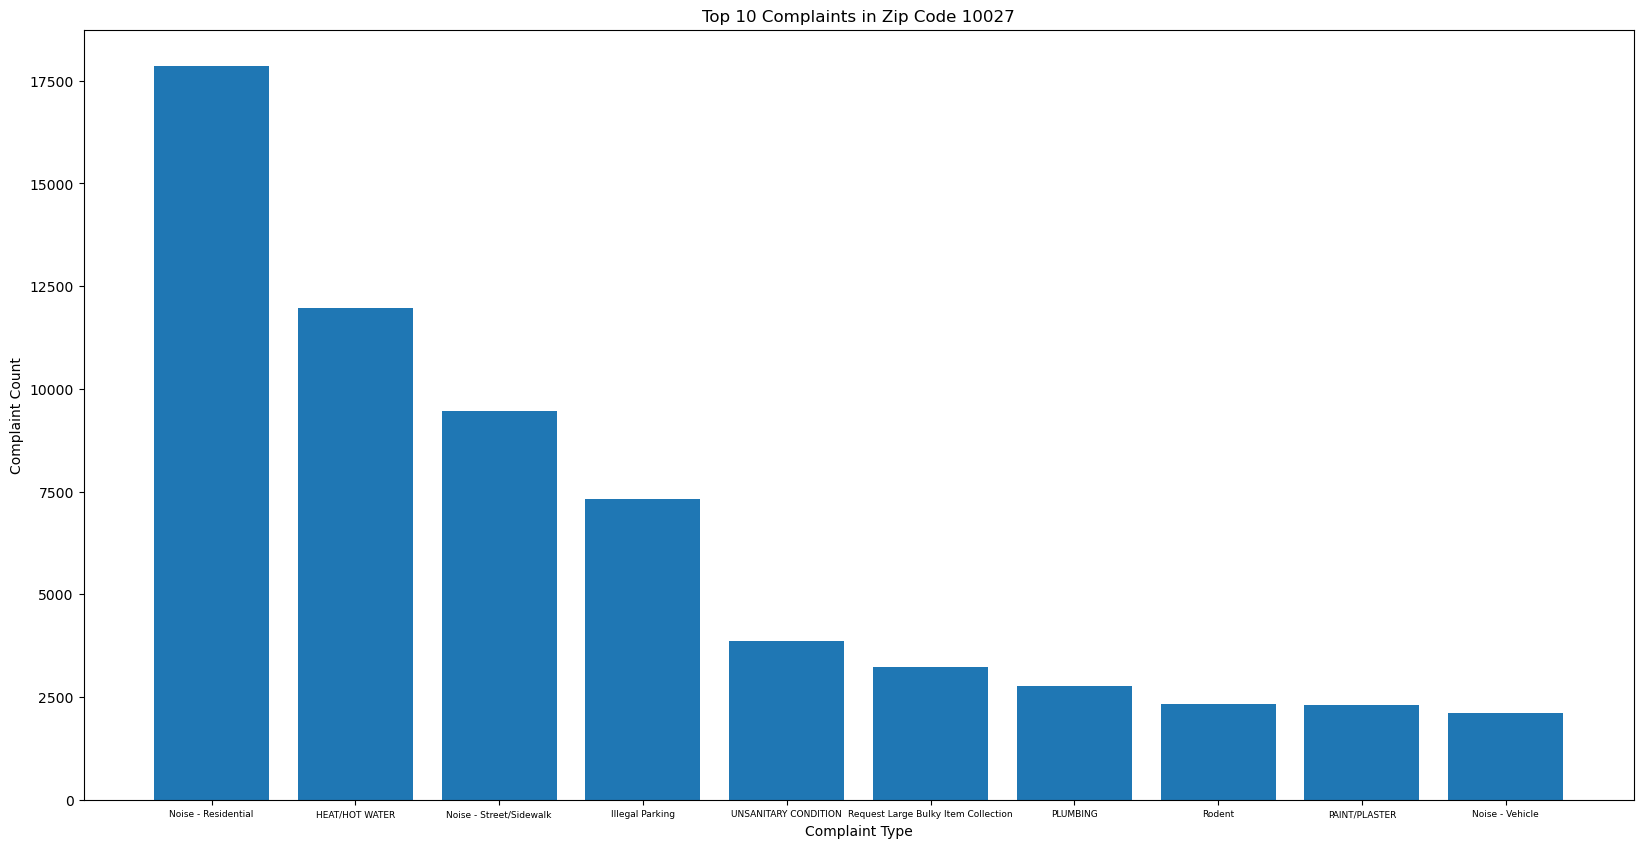

In [48]:
some_dataframe2 = get_data_for_visual_2()
plot_top_10_complaints(some_dataframe2)

### Visualization 3

**Is there any correlation between rent, trees, and complaints at all?**

The following graph contains two subplots of data between January 1st, 2015, and September 30th, 2023 (inclusive). One subplot shows the number of trees by zip code plotted against rent, and the other subplot shows the number of complaints by zip code plotted against rent.

We choose scatter plot because it is two-dimensional and it is straight forward when trying to identity any potential trend between two variables.

In [49]:
def plot_rent_trees_complaints(dataframe3):
    """Create a scaterr plot with 2 subplots for Visualization 3
    
    Key argument:
    dataframe3 -- a dataframe
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    #the scatter plot for Rent vs. Tree Count
    ax1.scatter(dataframe3['average_rent'], dataframe3['tree_count'])
    ax1.set_title("Average Rent vs Tree Count (Between January 1st, 2023 and September 30th, 2023)")
    ax1.set_xlabel("Average Rent")
    ax1.set_ylabel("Tree Count")

    #the scatter plot for Rent vs. Number of Complaints
    ax2.scatter(dataframe3['average_rent'], dataframe3['complaint_count'])
    ax2.set_title("Average Rent vs Number of Complaints (Between January 1st, 2023 and September 30th, 2023)")
    ax2.set_xlabel("Average Rent")
    ax2.set_ylabel("Complaint Count")

    plt.show()

In [50]:
def get_data_for_visual_3():
    """Query the data required for visualization 3 and return it as a dataframe"""
    
    V3 = """
    WITH aggregated_trees AS (
        SELECT zipcode, COUNT(*) AS tree_count
        FROM trees
        GROUP BY zipcode
    ),

    aggregated_complaints AS (
        SELECT zipcode, COUNT(*) AS complaint_count
        FROM nyc_311
        GROUP BY zipcode
    )

    SELECT average_rent, tree_count, complaint_count FROM rent
    JOIN 
        aggregated_trees ON aggregated_trees.zipcode = rent.zipcode
    JOIN 
        aggregated_complaints ON aggregated_complaints.zipcode = rent.zipcode
    """
   
    with engine.connect() as conn:
        result = conn.execute(db.text(V3))
        dataframe3 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe3

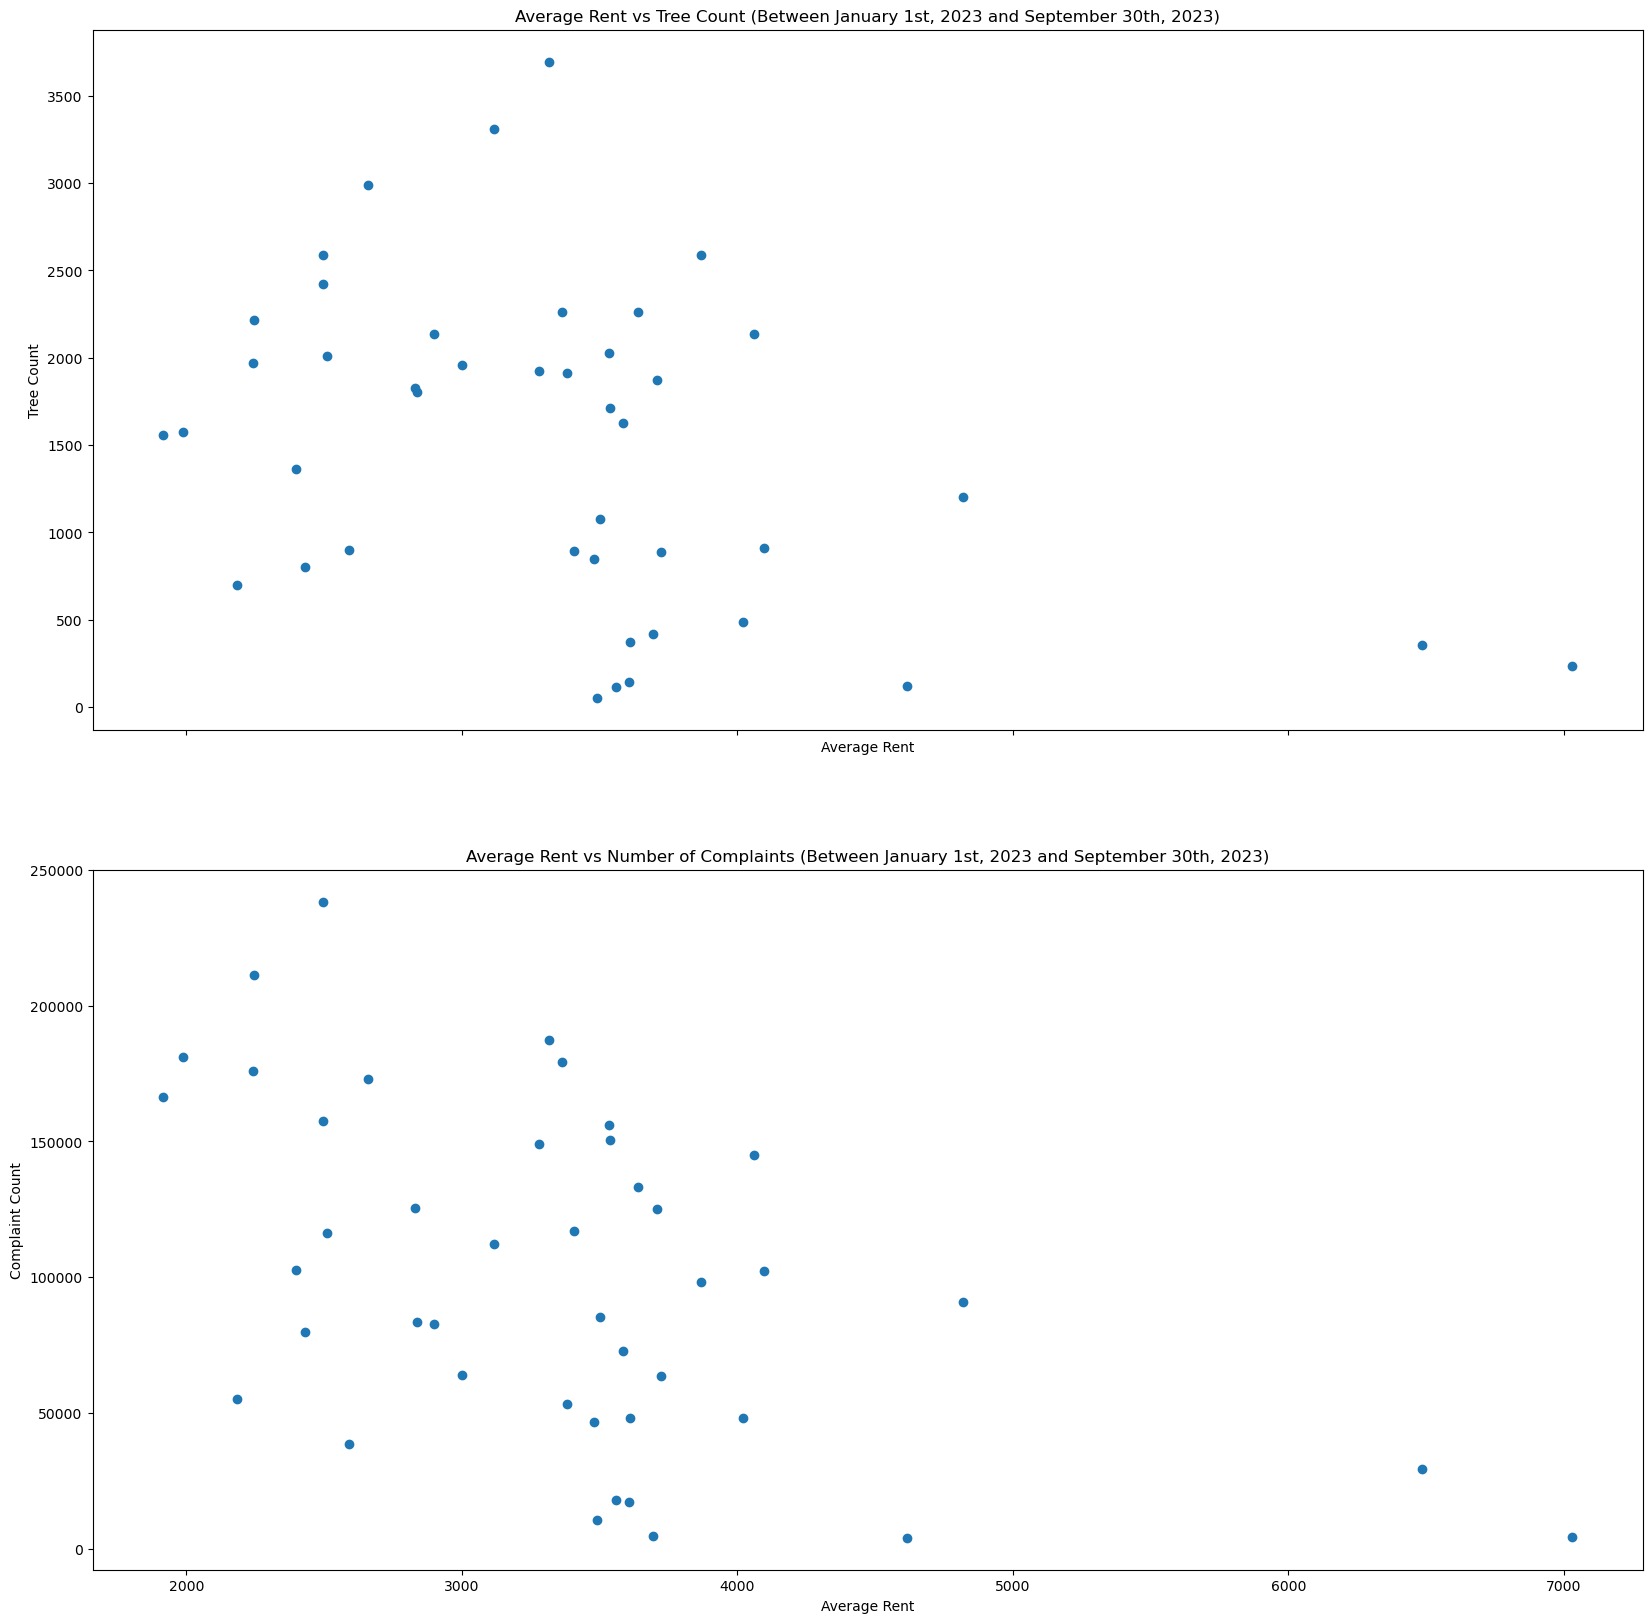

In [51]:
some_dataframe3 = get_data_for_visual_3()
plot_rent_trees_complaints(some_dataframe3)

### Visualization 4

**If I can afford more in rent, will there be fewer issues & complaints?**

The following graph contains boxplots of the number of compliants for different levels of average rent in September 2023.

In [52]:
def plot_rent_vs_complaints(dataframe4):
    """Create bar charts for Visualization 4
    
    Key argument:
    dataframe4 -- a dataframe
    """
    
    #cut bins
    dataframe4['RentBin'] = pd.cut(dataframe4['rent'], bins=range(0, int(dataframe4['rent'].max()) + 1000, 1000))
    
    plt.figure(figsize=(30, 30))
    
    #plot the box plots
    boxplot = dataframe4.boxplot(column='complaint_count', by='RentBin', showfliers=False)
    
    plt.title('Number of 311 Complaints vs. Average Rent (Steptemebr 2023)')
    plt.suptitle('')
    plt.xlabel('Average Rent (with Bin Width 1000)')
    plt.ylabel('Number of Complaints')
    plt.xticks(fontsize=7)
    
    plt.show()

In [53]:
def get_data_for_visual_4():
    """Query the data required for visualization 4 and return it as a dataframe"""
    
    V4 = """
    SELECT r.zipcode, r."2023-09-30" AS Rent, COUNT(*) AS complaint_count
    FROM nyc_311 n
    JOIN rent r ON n.zipcode = r.zipcode
    WHERE n.created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY r.zipcode, r."2023-09-30"
    ORDER BY r."2023-09-30";
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V4))
        dataframe4 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe4

<Figure size 3000x3000 with 0 Axes>

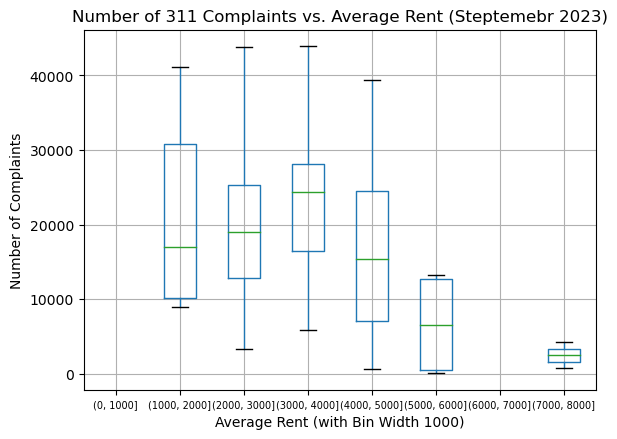

In [54]:
some_dataframe4 = get_data_for_visual_4()
plot_rent_vs_complaints(some_dataframe4)

### Visualization 5

**Where were the recent 311 incidents reported from in the immediate area?**

The following geospatial graph plots the coordinates of reported 311 incidents that happend between January 1st, 2023 and September 30th, 2023 (inclusive) and are within a 1 kilometer radius of the campus.

We choose scatter plot because it is two-dimensional and can present coordinates clearly.

In [55]:
def plot_recent_311_incidents(dataframe5):
    """Create a scaterr plot for Visualization 5
    
    Key argument:
    dataframe5 -- a dataframe
    """
    plt.figure(figsize=(20, 10))
    
    #Create scatter plot and plot locations of 311 incidents
    plt.scatter(dataframe5['longitude'], dataframe5['latitude'], marker='o', color='blue', 
                label='Recent Incidents')
    
    #Plot the location of campus
    plt.scatter(-73.96253174434912, 40.80737875669467, marker='x', color='red', alpha=0.5, 
                label='Reference Point (Campus)',s=100)
    
    plt.title("Recent 311 Incidents in Immediate Area")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc='upper left')
    
    plt.show()

In [56]:
def get_data_for_visual_5():
    """Query the data required for visualization 5 and return it as a dataframe"""
    
    V5 = """
    SELECT n.created_date, CAST(n.latitude AS NUMERIC), CAST(n.longitude AS NUMERIC)
    FROM nyc_311 n
    JOIN zip_codes z ON n.zipcode = z.zipcode
    WHERE n.created_date BETWEEN '2023-01-01' AND '2023-09-30' 
    AND ST_DistanceSphere(ST_MakePoint(CAST(n.longitude AS NUMERIC), CAST(n.latitude AS NUMERIC)), ST_MakePoint(-73.96253174434912,40.80737875669467)) <= 1000
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V5))
        dataframe5 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe5

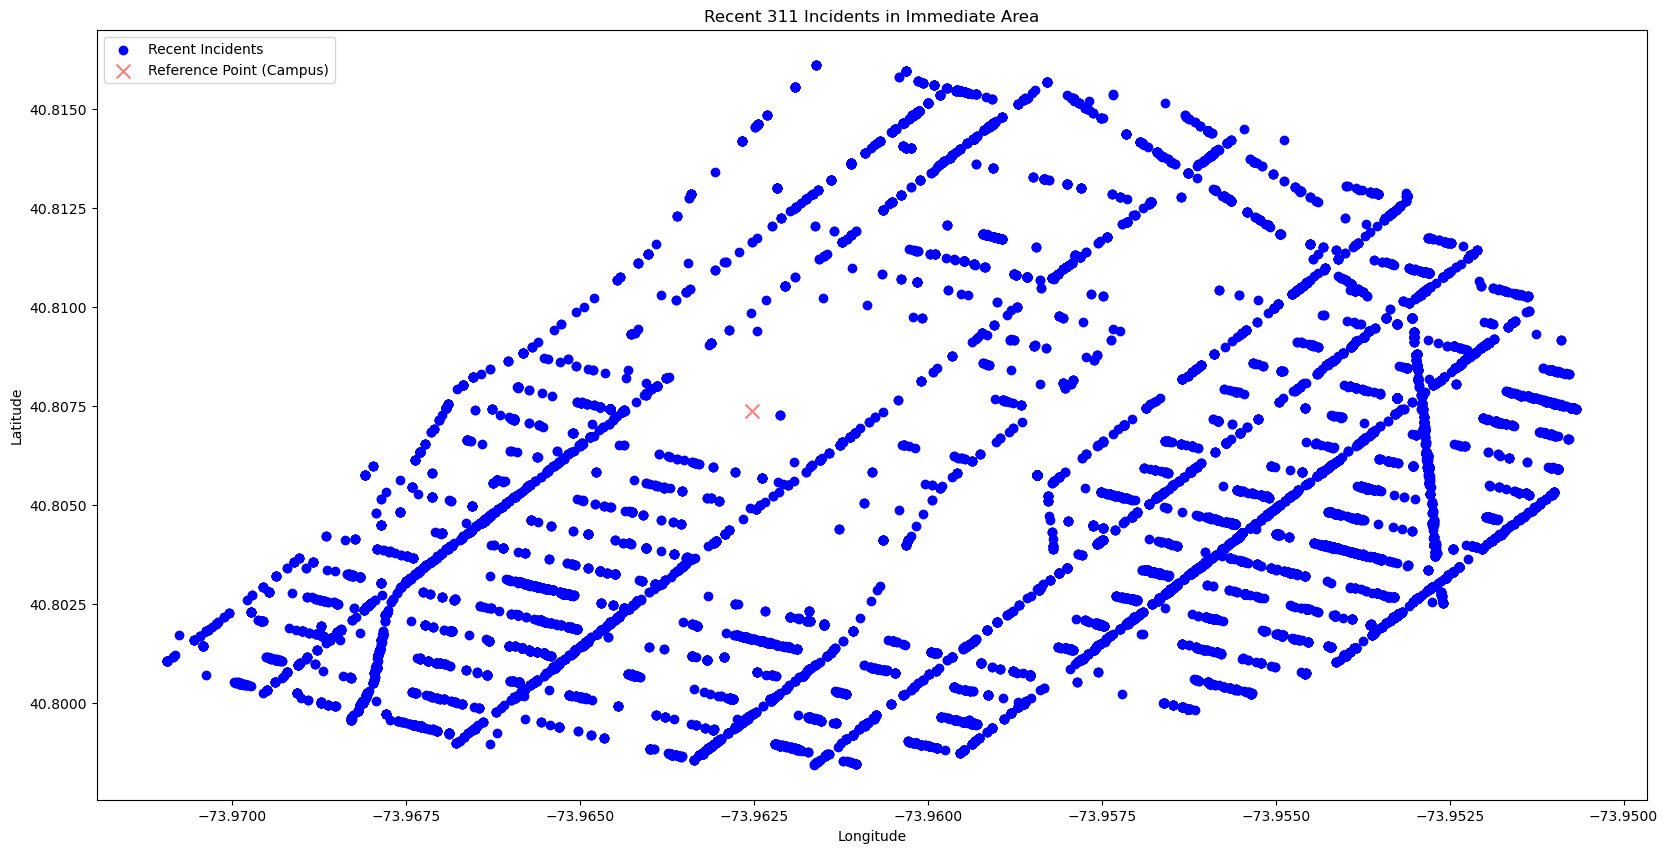

In [57]:
some_dataframe5 = get_data_for_visual_5()
plot_recent_311_incidents(some_dataframe5)

### Visualization 6

**Are areas trying to improve the amount of trees in the neighborhood?**

The following geospatial graph plots both the coordinates of trees in NYC and the coordinates of "New Tree Request" 311 complaints between October 1st, 2018 and September 30th, 2023 (inclusive). 

We choose scatter plot because it is two-dimensional and can present coordinates clearly.

In [58]:
def plot_trees_and_complaints(tree_df, complaints_df): 
    """Create a scaterr plot for Visualization 6
    
    Key argument:
    tree_df -- a dataframe
    complaints_df -- a dataframe
    """
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    
    temp_tree = tree_df.copy()
    
    #Extract longitude and latitude of trees
    temp_tree['temp_geom'] = temp_tree['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
    temp_tree['longitude'] = temp_tree['temp_geom'].apply(lambda geom: geom.centroid.x)
    temp_tree['latitude'] = temp_tree['temp_geom'].apply(lambda geom: geom.centroid.y)

    
    # Scatter plot for trees
    plt.scatter(temp_tree['longitude'], temp_tree['latitude'], marker='o', color='blue', 
                label='Trees')
    
    # Scatter plot for compliants
    plt.scatter(complaints_df['longitude'], complaints_df['latitude'], marker='x', color='red', 
                label='New Tree Requests')
    
    ax.legend()
    ax.set_title('Trees and New Tree Requests in NYC')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()

In [59]:
def get_data_for_visual_6():
    """Query the data required for visualization 6 and return it as a tuple of 2 dataframes"""
    
    V6_trees = """
    SELECT tree_id, the_geom
    FROM trees;
    """

    V6_complaints = """
    SELECT n.created_date, CAST(n.latitude AS NUMERIC), CAST(n.longitude AS NUMERIC), n.complaint_type
    FROM nyc_311 n
    JOIN zip_codes z ON n.zipcode = z.zipcode
    WHERE n.created_date BETWEEN '2018-10-01' AND '2023-10-01'
    AND complaint_type = 'New Tree Request';
    """

    with engine.connect() as conn:
        trees_result = conn.execute(db.text(V6_trees))
        complaints_result = conn.execute(db.text(V6_complaints))

        trees_df = gpd.GeoDataFrame(trees_result.fetchall(), columns=trees_result.keys())
        complaints_df = gpd.GeoDataFrame(complaints_result.fetchall(), columns=complaints_result.keys())

    return trees_df, complaints_df

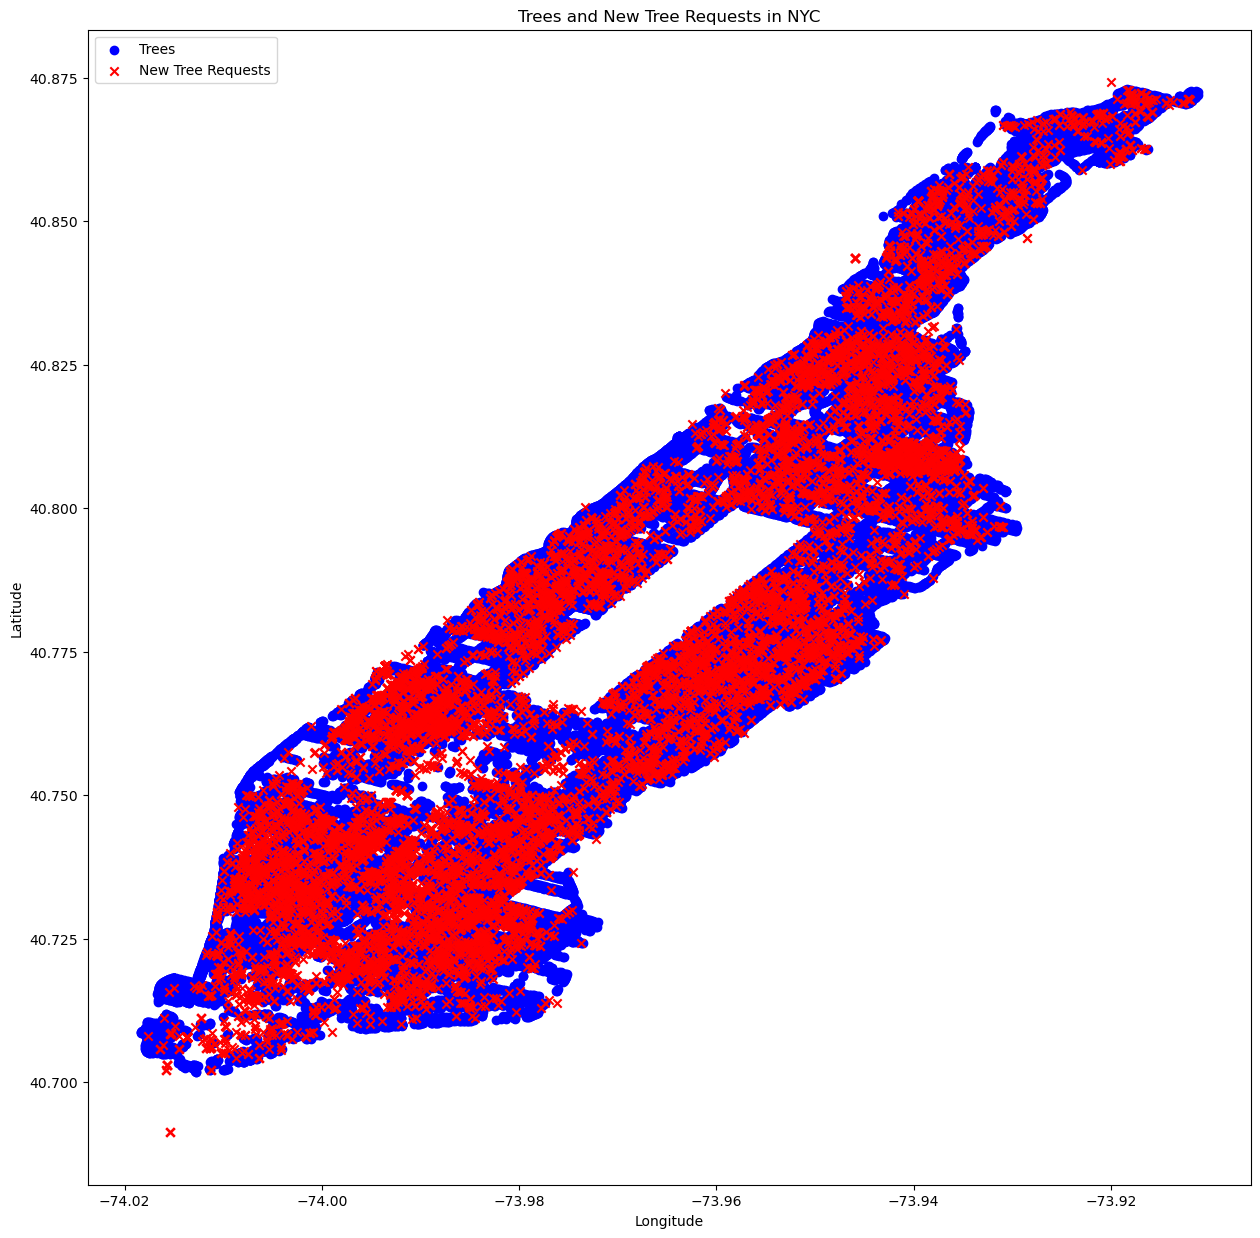

In [60]:
some_trees_df, some_complaints_df = get_data_for_visual_6()  
plot_trees_and_complaints(some_trees_df, some_complaints_df)